In [8]:
import os
from pathlib import Path

from scripts.renv_utils import activate_renv
from var_es_toolbox.data import load_data

activate_renv()
from rpy2.robjects import pandas2ri, globalenv
%load_ext rpy2.ipython

- renv activated -- please restart the R session.
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [9]:
project_dir = Path(os.getcwd()).resolve().parent
# Asset
asset = "DEBQc1_return"
globalenv["asset"] = str(asset)

# Retrieve data
data_dir = project_dir / "data"
data_cleaned_name = "refinitiv_data_merged.csv"
date_format = "ISO8601"
data_cleaned = load_data(data_dir / data_cleaned_name, date_format=date_format)
futures_returns = data_cleaned[asset].dropna()

# Retrieve r model
models_dir = project_dir / "src" / "var_es_toolbox" / "models"
backtest_dir = project_dir / "src" / "var_es_toolbox" / "backtesting"
hs_path = models_dir / "hs.R"
garch_path = models_dir / "garch.R"
gas_path = models_dir / "gas.R"
hybrid_evt_path = models_dir / "hybrid_evt.R"
caviar_path = models_dir / "caviar" / "caviar.R"
backtest_path = backtest_dir / "backtesting.R"

globalenv['hs_path'] = str(hs_path)
globalenv['garch_path'] = str(garch_path)
globalenv['gas_path'] = str(gas_path)
globalenv['hybrid_evt_path'] = str(hybrid_evt_path)
globalenv['caviar_path'] = str(caviar_path)
globalenv['backtest_path'] = str(backtest_path)

# r.source(str(r_arch_models_path))
# r.source(str(r_hybrid_evt_models_path))
# r.source(str(r_non_param_path))
# r.source(str(r_gas_models_path))
# r.source(str(r_caviar_models_path))

c = 0.05
t = 0.95
p = 1
q = 1
m = 500
n = 200
refit = 10

globalenv['df'] = pandas2ri.py2rpy(futures_returns.reset_index())
globalenv['df_all'] = pandas2ri.py2rpy(data_cleaned.reset_index())
globalenv['c'] = c
globalenv['p'] = p
globalenv['q'] = q
globalenv['m'] = m
globalenv['n'] = n
globalenv['refit'] = refit

In [10]:
%%R
library(xts)
library(rugarch)
library(psych)
library(ggplot2)             

names(df)[names(df) == asset] <- "Return"
dates <- tail(df$Date, n)
returns <- xts(tail(df$Return, n), order.by = dates)

desc_stat <- psych::describe(df_all)
print(desc_stat)

# Define the function for plotting returns, VaR, and ES
plot_var_es <- function(dates, returns, var, es) {
  # Create a data frame for plotting
  plot_data <- data.frame(
    Date = dates,
    Return = returns,
    VaR = var,
    ES = es
  )
  
  # Generate the plot using ggplot2 with labels
  ggplot(plot_data, aes(x = Date)) +
    geom_line(aes(y = Return, color = "Return"), linewidth = 0.7, alpha = 0.8) +    # Actual returns
    geom_line(aes(y = VaR, color = "VaR"), linetype = "dashed", linewidth = 0.7) + # VaR
    geom_line(aes(y = ES, color = "ES"), linetype = "dotted", linewidth = 0.7) +   # ES
    ggtitle("Actual Returns vs. VaR and ES") +
    xlab("Date") +
    ylab("Returns / VaR / ES") +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5),
      legend.position = "top"
    ) +
    scale_color_manual(values = c("Return" = "blue", "VaR" = "red", "ES" = "darkorange")) +
    scale_y_continuous(labels = scales::percent) +
    labs(color = "Legend")
}

                         vars    n    mean     sd  median trimmed    mad    min
Date                        1 2876     NaN     NA      NA     NaN     NA    Inf
DBc1                        2 1423  107.77 100.52   77.98   87.17  55.63   2.44
DBc1_return                 3 1423    0.00   0.34    0.00    0.00   0.19  -2.43
DPc1                        4 1420  112.94 106.51   78.10   91.18  55.29   0.01
DPc1_return                 5 1419    0.00   0.51    0.00    0.00   0.23  -7.70
DEBMc1                      6 1923   84.83  78.94   54.37   67.64  32.88  15.74
DEBMc1_return               7 1922    0.00   0.05    0.00    0.00   0.02  -0.50
DEPMc1                      8 1922   97.47  90.71   61.61   77.28  33.77  13.82
DEPMc1_return               9 1921    0.00   0.05    0.00    0.00   0.02  -0.41
DEBQc1                     10 1921  104.73 114.74   56.63   77.48  33.98  19.99
DEBQc1_return              11 1920    0.00   0.04    0.00    0.00   0.02  -0.44
DEPQc1                     12 1923  128.

In addition: Warning messages:
1: In FUN(newX[, i], ...) : no non-missing arguments to min; returning Inf
2: In FUN(newX[, i], ...) :
  no non-missing arguments to max; returning -Inf


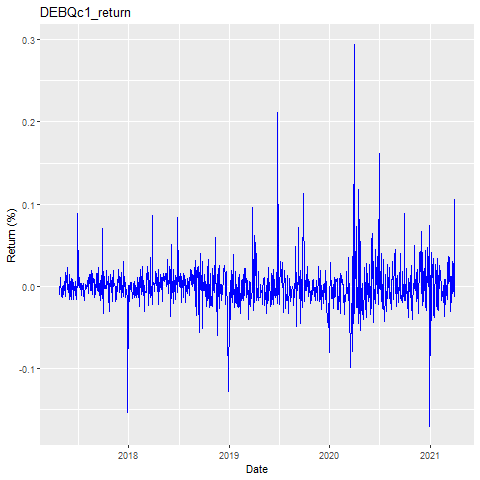

In [25]:
%%R

gg <- ggplot(df, aes(x=Date, y=Return)) +
    geom_line(color="blue") +
    ggtitle(asset) +
    xlab("Date") +
    ylab("Return (%)")
print(gg)

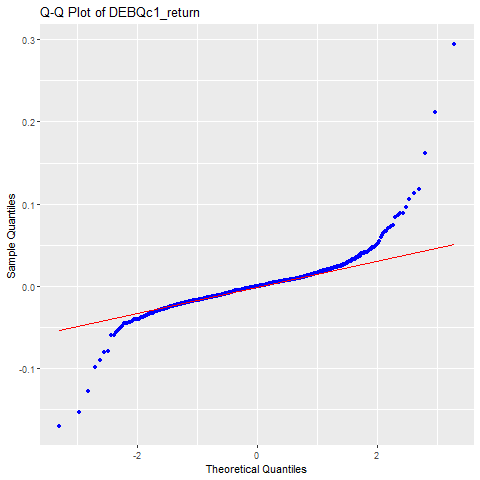

In [26]:
%%R

gg <- ggplot(df, aes(sample = Return)) +
    stat_qq(color = "blue") +
    stat_qq_line(color = "red") +
    ggtitle(paste("Q-Q Plot of", asset)) +
    xlab("Theoretical Quantiles") +
    ylab("Sample Quantiles")
print(gg)


Calculations completed.



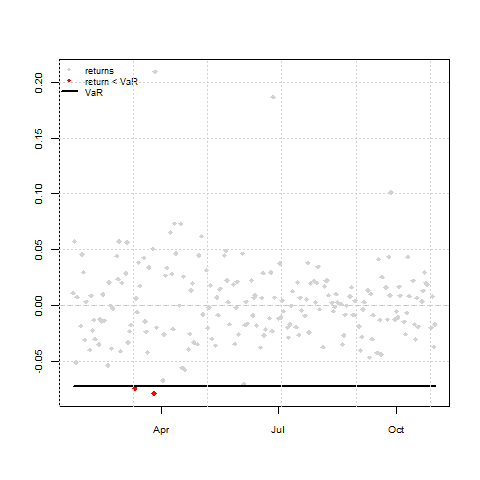

In [44]:
%%R
source(hs_path)

result <- forecast_u_HS(df, c, n, m)

var <- -result$VaR
VaRplot(c, returns, var)

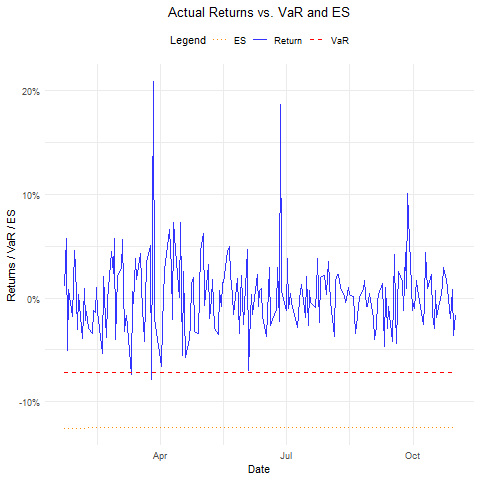

In [45]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [46]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, prefix = "HS")

   ExpectedExceedances ActualExceedances          UC          CC       VDT ER
HS                  10                 2 0.001657771 0.006960285 0.4133456  0
   ER_2 CoC         ESR1 ESR2         ESR3
HS    1   0 2.009504e-14    0 3.552714e-15



Calculations completed.



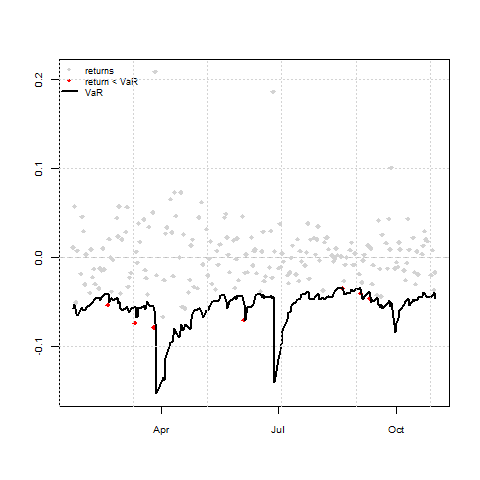

In [47]:
%%R

result <- forecast_u_FHS_GARCH(df, c, n, m)

var <- -result$VaR
VaRplot(c, returns, var)

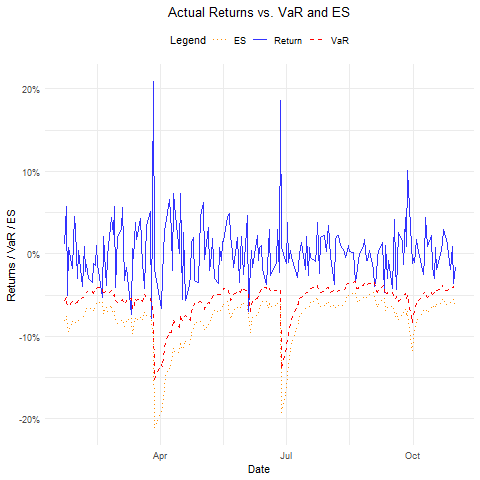

In [48]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [49]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, VOL = vol, prefix = "FHS")

    ExpectedExceedances ActualExceedances        UC       CC       VDT ER
FHS                  10                 7 0.3046629 0.457444 0.4385572  0
         ER_2       CoC       ESR1       ESR2       ESR3
FHS 0.9999999 0.0260549 0.05415445 0.05850067 0.03584355


NULL


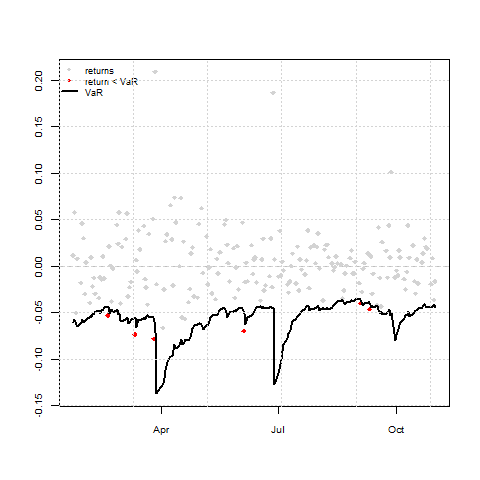

In [50]:
%%R
source(garch_path)

result <- forecast_u_GARCH(df, c, n, m, r = 100, model = "gjrGARCH", dist = "sstd")

var <- -result$VaR
print(VaRplot(c, returns, var))

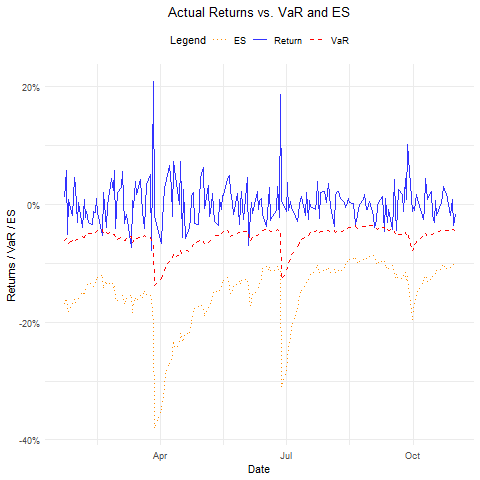

In [51]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [52]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, VOL = vol, prefix = "GJR-GARCH")

          ExpectedExceedances ActualExceedances        UC        CC       VDT
GJR-GARCH                  10                 6 0.1621867 0.3124166 0.4839754
          ER ER_2       CoC ESR1 ESR2         ESR3
GJR-GARCH  0    1 0.0144173    0    0 4.795451e-10


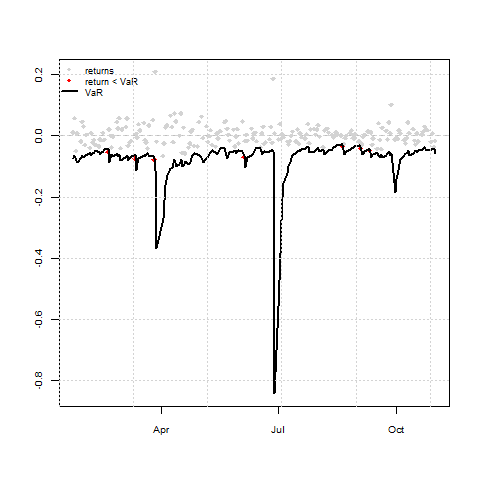

In [56]:
%%R
source(gas_path)

result <- forecast_u_GAS(df, c, n, m, r = 10, dist = "sstd")

var <- -result$VaR
VaRplot(c, returns, var)

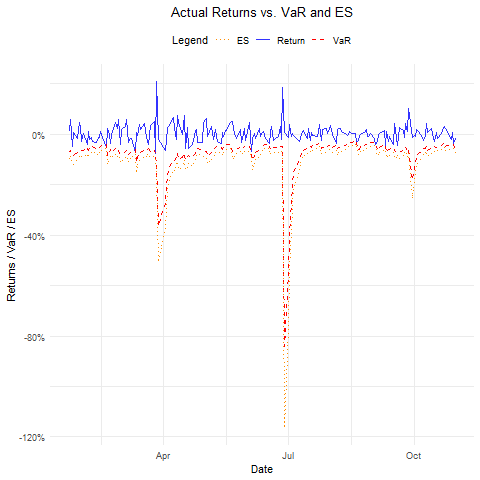

In [59]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [60]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, prefix = "GAS")

    ExpectedExceedances ActualExceedances        UC       CC       VDT ER
GAS                  10                 7 0.3046629 0.457444 0.4385572  0
         ER_2          CoC ESR1 ESR2      ESR3
GAS 0.9999343 5.495604e-14    0    0 0.1411908


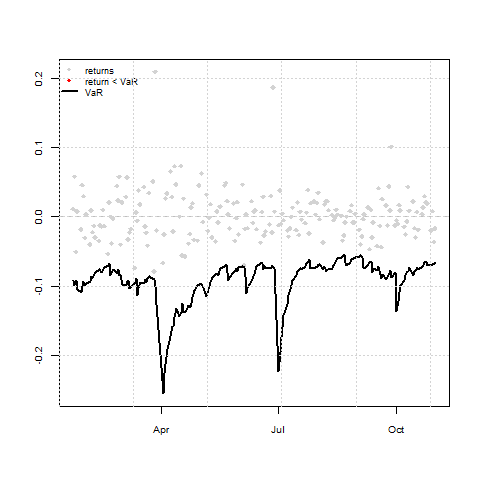

In [64]:
%%R
source(hybrid_evt_path)

result <- forecast_u_EVT_GARCH(df, 0.01, n, m, t = 0.95)

var <- -result$VaR
VaRplot(c, returns, var)

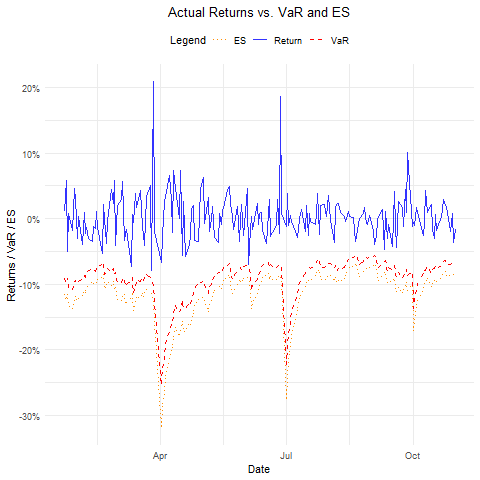

In [65]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [32]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, VOL = vol, prefix = "EVT_GARCH")

Error in `[.default`(n, 2, 2) : subscript out of bounds


RInterpreterError: Failed to parse and evaluate line 'source(backtest_path)\n\nvol <- result$VOL\nrun_backtests(returns, var, es, c, VOL = vol, prefix = "EVT_GARCH")\n'.
R error message: 'Error in `[.default`(n, 2, 2) : subscript out of bounds'

In [11]:
%%R
source(caviar_path)

result <- forecast_u_CAViaR(df, c, n, m, r = 100, var_model = "SAV", es_model="AR")

var <- -result$VaR
VaRplot(c, returns, var)
warnings()

Error in value[[3L]](cond) : 
  error while calling `package.skeleton` : no R objects specified or available
In addition: Warning message:
In package.skeleton(name = "caviar", list = "Rcpp.fake.fun") :
  object ''Rcpp.fake.fun'' not found
Error in value[[3L]](cond) : 
  error while calling `package.skeleton` : no R objects specified or available


RInterpreterError: Failed to parse and evaluate line 'source(caviar_path)\n\nresult <- forecast_u_CAViaR(df, c, n, m, r = 100, var_model = "SAV", es_model="AR")\n\nvar <- -result$VaR\nVaRplot(c, returns, var)\nwarnings()\n'.
R error message: 'Error in value[[3L]](cond) : \n  error while calling `package.skeleton` : no R objects specified or available'
R stdout:
Error in value[[3L]](cond) : 
  error while calling `package.skeleton` : no R objects specified or available
In addition: Warning message:
In package.skeleton(name = "caviar", list = "Rcpp.fake.fun") :
  object ''Rcpp.fake.fun'' not found

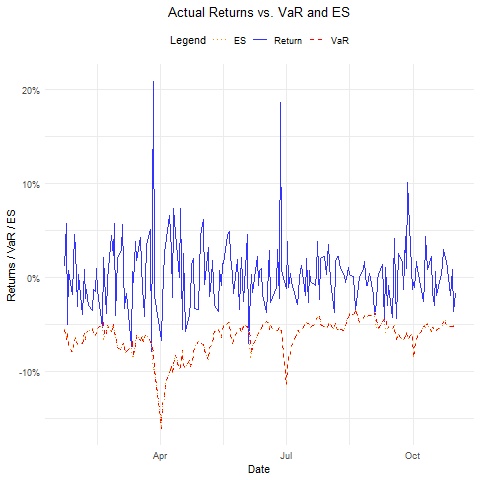

In [51]:
%%R

es <- -result$ES
print(plot_var_es(dates, returns, var, es))

In [52]:
%%R
source(backtest_path)

vol <- result$VOL
run_backtests(returns, var, es, c, prefix = "CAVIAR")

       ExpectedExceedances ActualExceedances        UC        CC       VDT ER
CAVIAR                  10                 6 0.1621867 0.3124166 0.4839754  0
              ER_2          CoC      ESR1      ESR2      ESR3
CAVIAR 0.007346433 0.0002203004 0.9565512 0.9861911 0.6250224
